# Loading in the Data

Downloading the dataset from Kaggle and creating a Pandas dataframe.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.optimizers import Adam
from getpass import getpass

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
user = getpass('Kaggle Username: ')
key = getpass('Kaggle API key: ')
# You need to provide your Kaggle username and API key
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

Kaggle Username: ··········
Kaggle API key: ··········


In [3]:
!mkdir -p electricity_data
!kaggle datasets download -d robikscube/hourly-energy-consumption -p electricity_data

 44% 5.00M/11.4M [00:00<00:00, 23.5MB/s]
100% 11.4M/11.4M [00:00<00:00, 38.1MB/s]


In [4]:
!kaggle datasets files robikscube/hourly-energy-consumption

name                  size  creationDate         
-------------------  -----  -------------------  
AEP_hourly.csv         3MB  2018-08-30 14:17:03  
PJM_Load_hourly.csv  900KB  2018-08-30 14:17:03  
PJME_hourly.csv        4MB  2018-08-30 14:17:03  
pjm_hourly_est.csv    12MB  2018-08-30 14:17:03  
DAYTON_hourly.csv      3MB  2018-08-30 14:17:03  
NI_hourly.csv          2MB  2018-08-30 14:17:03  
est_hourly.paruqet     4MB  2018-08-30 14:17:03  
COMED_hourly.csv       2MB  2018-08-30 14:17:03  
EKPC_hourly.csv        1MB  2018-08-30 14:17:03  
PJMW_hourly.csv        4MB  2018-08-30 14:17:03  
DOM_hourly.csv         3MB  2018-08-30 14:17:03  
DEOK_hourly.csv        1MB  2018-08-30 14:17:03  
DUQ_hourly.csv         3MB  2018-08-30 14:17:03  
FE_hourly.csv          2MB  2018-08-30 14:17:03  


In [5]:
!unzip -o -q electricity_data/hourly-energy-consumption.zip
df = pd.read_csv('DAYTON_hourly.csv')
df.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


# Data Pre-processing


Goals:


1.   Add an "id" column
2.   Change datetime to python datetime
3.   Check to make sure the two columns ('Datetime' and 'DAYTON_MW') are clean





In [6]:
# Goal 1
df['id'] = np.arange(1, len(df) + 1)
df.head()

,Datetime,DAYTON_MW,id
0,2004-12-31 01:00:00,1596.0,1
1,2004-12-31 02:00:00,1517.0,2
2,2004-12-31 03:00:00,1486.0,3
3,2004-12-31 04:00:00,1469.0,4
4,2004-12-31 05:00:00,1472.0,5


In [7]:
# Goal 2
from datetime import timedelta

start_date = df[df['id'] == 1]['Datetime']
end_date = df[df['id'] == (len(df) + 1)]['Datetime']

pred_steps = 14
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(start_date)
last_day = pd.to_datetime(end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [8]:
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df['DAYTON_MW'] = pd.to_numeric(df['DAYTON_MW'], errors='coerce')
df = df.dropna()

In [9]:
df.info()
df = df.set_index('Datetime')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121275 entries, 0 to 121274
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Datetime   121275 non-null  datetime64[ns]
 1   DAYTON_MW  121275 non-null  float64       
 2   id         121275 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.7 MB


In [10]:
hours_in_future = 24

labels = df[['DAYTON_MW']].shift(-1 * hours_in_future)
labels.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1713.0
2004-12-31 02:00:00,1647.0
2004-12-31 03:00:00,1611.0
2004-12-31 04:00:00,1608.0
2004-12-31 05:00:00,1630.0


In [12]:
X = df.values[0:-1 * hours_in_future]
y = labels.values[0: - 1 * hours_in_future]
print(X.shape, y.shape)

(121251, 2) (121251, 1)


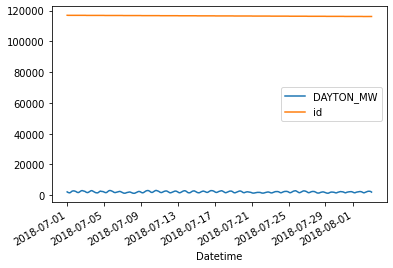

In [14]:
df[df.index >= '2018-07-01'].plot()

In [ ]:
# data is clean - no null values
print(df[df['Datetime'].isnull()])
print(df[df['DAYTON_MW'].isnull()])

Empty DataFrame
Columns: [Datetime, DAYTON_MW, id]
Index: []
Empty DataFrame
Columns: [Datetime, DAYTON_MW, id]
Index: []


In [ ]:
# No negative values or values that are too high
df['DAYTON_MW'].describe()

count    121275.000000
mean       2037.851140
std         393.403153
min         982.000000
25%        1749.000000
50%        2009.000000
75%        2279.000000
max        3746.000000
Name: DAYTON_MW, dtype: float64

In [ ]:
# Hourly measurements are taken: starting at 1 AM on Dec 31 2004, ending on Jan 2 2018 at midnight
# Very clean dataset
df['Datetime'].describe()

count                  121275
unique                 121271
top       2014-11-02 02:00:00
freq                        2
Name: Datetime, dtype: object

# Data Exploration

Creating graphs to visualize and further understand the data.

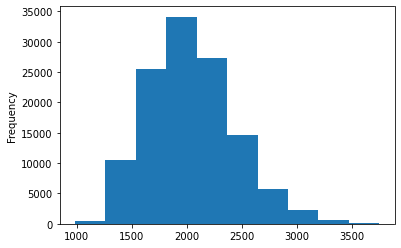

In [ ]:
df['DAYTON_MW'].plot.hist()

It looks like the average megawatt reading is around 2000 MW.

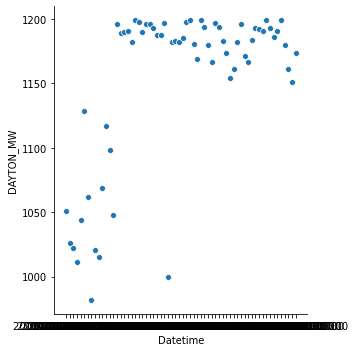

In [ ]:
test_df = df.loc[df['DAYTON_MW'] < 1200]
sns.relplot(x='Datetime', y='DAYTON_MW', data=test_df)

This graph shows that as time goes on, people use more and more electricity (then again, this is only a small sample of all the readings: < 1200 MW).

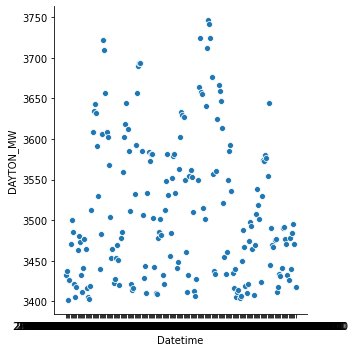

In [ ]:
test_df2 = df.loc[df['DAYTON_MW'] > 3400]
sns.relplot(x='Datetime', y='DAYTON_MW', data=test_df2)

The above graph doesn't show the same pattern that the previous graph showed. In this one, the MW readings are all spread out.

# To be done



1.   Create train_test split
2.   Implement simple ML algorithm, analyze the results.

